Inputs: channel estimate, n bits where n-1 bits are previous estimates of x values and the nth value is the next convolved sample

Outputs: estimates of x values

Recursive: feed back the n-1 estimates

In [2]:
import numpy as np
import scipy.signal as sig

# Create training and test data for the NN

epochs = 1000
batch_size = 100

# number of random channels that will be trained and tested on
num_train=epochs*batch_size
num_test=batch_size
beta=0
# assume we know the channel_length
channel_length = 2

# assume we are working with just real parts
channel_train = np.zeros((num_train,channel_length))
channel_test = np.zeros((num_test,channel_length))

data_length = 100

# BPSK, only real parts
data_train_orig = np.zeros((num_train, data_length+1))
data_train = np.zeros((num_train,data_length+1))
data_test_orig = np.zeros((num_test,data_length+1))
data_test = np.zeros((num_test,data_length+1))

for i in range(0, num_train):
    channel_train[i,:]=np.random.uniform(beta,1,channel_length)
    # if the total power is greater than 1, then normalize
#     if sum(channel_train[i])>=1:
#         channel_train[i] = channel_train[i]/(sum(channel_train[i]))

    # normalize power to 1
    channel_train[i] = channel_train[i]/(np.linalg.norm(channel_train[i]))
    
    data_train_basic = 2*np.random.randint(2,size=data_length)-1
    data_train_orig[i,:]=np.pad(data_train_basic, (0, 1), 'constant')
    data_train[i,:]=sig.convolve(data_train_basic, channel_train[i], mode='full')
    
    if i % 100000 == 0:
        print(i)
    

for i in range(0, num_test):
    channel_test[i,:]=np.random.uniform(beta,1,channel_length)
    # if the total power is greater than 1, then normalize
#     if sum(channel_test[i])>=1:
#         channel_test[i] = channel_test[i]/(sum(channel_test[i]))

    # normalize power to 1
    channel_test[i] = channel_test[i]/(np.linalg.norm(channel_test[i]))
    
    data_test_basic = 2*np.random.randint(2,size=data_length)-1
    data_test_orig[i,:]=np.pad(data_test_basic, (0, 1), 'constant')
    data_test[i,:]=sig.convolve(data_test_basic, channel_test[i], mode='full')

0


In [25]:
print(data_test[0].shape)

(101,)


# Simple RNN 
Feed in 1 input bit and feedback 4 bits

In [3]:
import numpy as np
from numpy import linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
# fix random seed for reproducibility
np.random.seed()

learning_rate = 0.01
decay = 1 - 10*1e-10

batch_size = 100 # num of data streams
input_size = 1 # num of new conv data points to consider
state_size = 4 # num of est data points to use as state

batch_data_placeholder = tf.placeholder(tf.float32, [None, data_length+1])
batch_dataorig_placeholder = tf.placeholder(tf.float32, [None, data_length+1])

channel = tf.placeholder(tf.float32, [None, channel_length])

init_state = tf.placeholder(tf.float32, [None, state_size])

# Unpack columns
data = tf.unstack(batch_data_placeholder, axis=1)
data_orig = tf.unstack(batch_dataorig_placeholder, axis=1)

# Forward pass
current_state = init_state
est_data_series = []
for current_data in data:
    current_input = tf.reshape(current_data, [batch_size, input_size])

    # Increasing number of columns
    input_channel_state_concatenated = tf.concat([channel, current_state, current_input],1)  
    
    layer_1 = tf.layers.dense(
      input_channel_state_concatenated, 400, tf.nn.sigmoid, use_bias=True)
    layer_2 = tf.layers.dense(
      layer_1, 400, tf.nn.sigmoid, use_bias=True)
    layer_3 = tf.layers.dense(
      layer_2, state_size, activation=tf.identity, use_bias=True)

    next_state = layer_3
#     print(next_state[:,0])

    est_data_series.append(next_state[:,0])
#     print(est_data_series)
#     print(np.array(est_data_series).shape)
    current_state = next_state
    
# print(tf.size(est_data_series))
# print(tf.size(data_orig))

estimation_cost = tf.losses.mean_squared_error(data_orig, est_data_series)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(estimation_cost)
                                                                                  
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()



Epoch 0, Train Cost 1.5184996128082275, Test Cost: 106.16715240478516
Epoch 100, Train Cost 0.6346083283424377, Test Cost: 0.5885627865791321
Epoch 200, Train Cost 0.5015140771865845, Test Cost: 0.5050040483474731
Epoch 300, Train Cost 0.4697097837924957, Test Cost: 0.4742852747440338
Epoch 400, Train Cost 0.3384108245372772, Test Cost: 0.42466530203819275
Epoch 500, Train Cost 0.35659292340278625, Test Cost: 0.34094372391700745
Epoch 600, Train Cost 0.2985323369503021, Test Cost: 0.2667490243911743
Epoch 700, Train Cost 0.26166340708732605, Test Cost: 0.21364136040210724
Epoch 800, Train Cost 0.21784928441047668, Test Cost: 0.1709526926279068
Epoch 900, Train Cost 0.2594517171382904, Test Cost: 0.22098401188850403


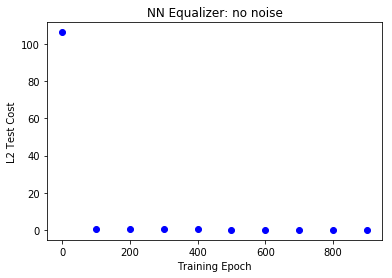

In [4]:
plt.figure()

# start the session
with tf.Session() as sess:
    #    initialize the variables
    sess.run(init_op)
    mc_losses = []
    
    for epoch in range(epochs):
        
        current_start = epoch*batch_size
        channel_train_batch = channel_train[current_start:(current_start+batch_size),:]
        data_train_batch = data_train[current_start:(current_start+batch_size),:]
        data_train_orig_batch = data_train_orig[current_start:(current_start+batch_size),:]
        
        # begin in state of all zeros
        begin_state = np.zeros((batch_size, state_size))
        
#         print(data_train_batch.shape)
#         print(channel_train_batch.shape)
#         print(data_train_orig_batch.shape)
#         print(begin_state.shape)
        _,cost,est_data_batch = sess.run([optimizer, estimation_cost, est_data_series], 
                                          feed_dict={batch_data_placeholder: data_train_batch, 
                                                     channel: channel_train_batch,
                                                     batch_dataorig_placeholder: data_train_orig_batch,
                                                     init_state: begin_state})    

        if epoch % 100 == 0: 
            
            
            mc_cost, mc_estimation = sess.run([estimation_cost, est_data_series], 
                                             feed_dict={batch_data_placeholder: data_test, 
                                                        channel: channel_test,
                                                        batch_dataorig_placeholder: data_test_orig,
                                                        init_state: begin_state})
            
            
            plt.plot(epoch, mc_cost, 'bo')
#             plt.plot(epoch, zero_force_error, 'ro')
#             plt.plot(epoch, mse_error, 'go')
            print('Epoch {}, Train Cost {}, Test Cost: {}'.format(epoch, cost, mc_cost))
#             plt.plot(epoch,cost,'bo')
#             print('Epoch {}, Train Cost {}'.format(epoch, cost))
            

plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()


# Heat Map for RNN

In [36]:
from scipy.interpolate import griddata

def gen_data_for_plot(sess, outputs, inputs, preamble=None):
    n = 300
    if preamble is None:
        n_repeat = 10
        preambles = [gen_preamble() for _ in range(n_repeat)]
    else:
        n_repeat = 1
        preambles = [preamble]
    rad = np.linspace(0, 0.5*np.pi, n)
    channels = np.vstack((np.cos(rad),np.sin(rad))).T
    snrs = np.logspace(-4,4,20)
    errors_nn = np.zeros((n*len(snrs)))
    errors_ls = np.zeros((n*len(snrs)))
    channel_x = np.zeros((n*len(snrs)))
    channel_y = np.zeros((n*len(snrs)))
    for i in range(len(snrs)):
        for preamble in preambles:
            s = snrs[i]
            received = apply_channel(channels, preamble, snr=s)
            received_ = received[:,:-1].reshape((n,100,1))
            channel_hat_nn = sess.run(outputs[0], feed_dict={inputs[0]:preamble.reshape((1, 100, 1)),
                                 inputs[1]:received_})
            for j in range(len(received)):
                channel_hat_ls[j] = LS_channel_est(preamble, received[j])

            errors_nn[i*n:(i+1)*n] += np.mean((channel_hat_nn - channels)**2,axis=1)
            errors_ls[i*n:(i+1)*n] += np.mean((channel_hat_ls - channels)**2,axis=1)
        errors_nn[i*n:(i+1)*n] /= n_repeat
        errors_ls[i*n:(i+1)*n] /= n_repeat

        channel_x[i*n:(i+1)*n] = channels[:,0]*s
        channel_y[i*n:(i+1)*n] = channels[:,1]*s
    
    return channel_x, channel_y, errors_nn, errors_ls
        
def heat_plot(channel_x, channel_y, errors_zf, errors_nneq):
    X = channel_x
    Y = channel_y
    Z1 = np.log10(errors_zf)
    Z2 = np.log10(errors_nneq)
    # create x-y points to be used in heatmap
    xi = np.logspace(-4, 4,100)
    yi = np.logspace(-4, 4,100)

    # Z is a matrix of x-y values
    zi1 = griddata((X, Y), Z1, (xi[None,:], yi[:,None]), method='linear')
    zi2 = griddata((X, Y), Z2, (xi[None,:], yi[:,None]), method='linear')

    # direction = channel, radius = SNR
    f, ax = plt.subplots(1, 2, figsize = (8*2, 6),sharex=True,sharey=True)
    ax[0].set_title('RNN equalizer L2 error, log scale')
    ax[1].set_title('RNN equalizer L2 error, log scale')
    CS1 = ax[0].contourf(xi, yi, zi1, 15, cmap=plt.cm.rainbow, vmin=-10, vmax=2)
    CS2 = ax[1].contourf(xi, yi, zi2, 15, cmap=plt.cm.rainbow, vmin=-10, vmax=2)

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')

    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    f.colorbar(CS1, cax=cbar_ax)

    ax[0].set_xlabel("(tap 1 value) x (channel SNR), log scale")
    ax[1].set_xlabel("(tap 1 value) x (channel SNR), log scale")
    ax[0].set_ylabel("(tap 2 value) x (channel SNR), log scale")
    ax[1].set_ylabel("(tap 2 value) x (channel SNR), log scale")


    plt.show()
    f.savefig(fname='rnn_equalizer_2tap')
    print(type(f))
    plt.close()

In [14]:
def apply_channel(channel, data, snr=-1):
    ret = sig.convolve(data, channel, mode='full')
    if snr > 0:
        ret += (1./np.sqrt(snr)) * np.random.randn(len(ret))
    return ret

In [21]:
import numpy as np
from numpy import linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

def train_eq_rnn(data_length, channel_length, channel_train, data_train, data_train_orig,
               channel_test,data_test, data_test_orig,errors_rnneq,channels_heat_map,data_heat_map_orig,i):
    
    m=data_length+1
    
    learning_rate = 0.01
    input_size = 1 # num of new conv data points to consider
    state_size = 4 # num of est data points to use as state

    batch_data_placeholder = tf.placeholder(tf.float32, [None, data_length+1])
    batch_dataorig_placeholder = tf.placeholder(tf.float32, [None, data_length+1])

    channel = tf.placeholder(tf.float32, [None, channel_length])

    init_state = tf.placeholder(tf.float32, [None, state_size])

    # Unpack columns
    data = tf.unstack(batch_data_placeholder, axis=1)
    data_orig = tf.unstack(batch_dataorig_placeholder, axis=1)

    # Forward pass
    current_state = init_state
    est_data_series = []
    for current_data in data:
        current_input = tf.reshape(current_data, [batch_size, input_size])

        # Increasing number of columns
        input_channel_state_concatenated = tf.concat([channel, current_state, current_input],1)  

        layer_1 = tf.layers.dense(
          input_channel_state_concatenated, 400, tf.nn.sigmoid, use_bias=True)
        layer_2 = tf.layers.dense(
          layer_1, 400, tf.nn.sigmoid, use_bias=True)
        layer_3 = tf.layers.dense(
          layer_2, state_size, activation=tf.identity, use_bias=True)

        next_state = layer_3

        est_data_series.append(next_state[:,0])
        current_state = next_state

    estimation_cost = tf.losses.mean_squared_error(data_orig, est_data_series)

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(estimation_cost)

    # finally setup the initialisation operator
    init_op = tf.global_variables_initializer()

    #     plt.figure()

    # start the session
    with tf.Session() as sess:
        #    initialize the variables
        sess.run(init_op)
        mc_losses = []

        for epoch in range(epochs):

            current_start = epoch*batch_size
            channel_train_batch = channel_train[current_start:(current_start+batch_size),:]
            data_train_batch = data_train[current_start:(current_start+batch_size),:]
            data_train_orig_batch = data_train_orig[current_start:(current_start+batch_size),:]

            # begin in state of all zeros
            begin_state = np.zeros((batch_size, state_size))

            _,cost,est_data_batch = sess.run([optimizer, estimation_cost, est_data_series], 
                                              feed_dict={batch_data_placeholder: data_train_batch, 
                                                         channel: channel_train_batch,
                                                         batch_dataorig_placeholder: data_train_orig_batch,
                                                         init_state: begin_state})    

            if epoch % 100 == 0: 


                mc_cost, mc_estimation = sess.run([estimation_cost, est_data_series], 
                                                 feed_dict={batch_data_placeholder: data_test, 
                                                            channel: channel_test,
                                                            batch_dataorig_placeholder: data_test_orig,
                                                            init_state: begin_state})


                print('Epoch {}, Train Cost {}, Test Cost: {}'.format(epoch, cost, mc_cost))

#         # TEST OVER THE HEAT MAP SPACE
        
        data_heat_map_nn = np.pad(data_heat_map_orig, (0, 1), 'constant').reshape((1,101))
        
        for k in range(0,n):
            current_channel = channels_heat_map[k,:]
#             err = 0
            batch_heat_map_channels = np.zeros((batch_size,channel_length))
            batch_data_heat_map_orig = np.zeros((batch_size,m))
            batch_data_heat_map_received = np.zeros((batch_size,m))
            for j in range(0,batch_size): # average error over 100 trials
                received = apply_channel(current_channel, data_heat_map_orig, snr=s)
                batch_data_heat_map_received[j,:] = received.reshape((1,101))
                batch_heat_map_channels[j,:]= current_channel.reshape((1,2))
                batch_data_heat_map_orig[j,:] = data_heat_map_nn
            rnn_eq_cost = sess.run([estimation_cost], 
                                    feed_dict={batch_data_placeholder: batch_data_heat_map_received, 
                                               channel: batch_heat_map_channels,
                                               batch_dataorig_placeholder: batch_data_heat_map_orig,
                                               init_state: begin_state})
#             print(rnn_eq_cost)
#             err = err + rnn_eq_cost[0]
            errors_rnneq[i*n+k] = rnn_eq_cost[0]
    
    return errors_rnneq

Epoch 0, Train Cost 1.6144709587097168, Test Cost: 1.6774885654449463
Epoch 100, Train Cost 0.5783942937850952, Test Cost: 0.5899437665939331
Epoch 200, Train Cost 0.5222545862197876, Test Cost: 0.5329954028129578
Epoch 300, Train Cost 0.5470625758171082, Test Cost: 0.540459156036377
Epoch 400, Train Cost 0.4846600890159607, Test Cost: 0.5577387809753418
Epoch 500, Train Cost 0.49293920397758484, Test Cost: 0.5336682200431824
Epoch 600, Train Cost 0.5463094711303711, Test Cost: 0.539617121219635
Epoch 700, Train Cost 0.5076443552970886, Test Cost: 0.5376457571983337
Epoch 800, Train Cost 0.46263569593429565, Test Cost: 0.5272119641304016
Epoch 900, Train Cost 0.5120766162872314, Test Cost: 0.5285106897354126
Epoch 1000, Train Cost 0.5166832804679871, Test Cost: 0.5373431444168091
Epoch 1100, Train Cost 0.5813274383544922, Test Cost: 0.5274563431739807
Epoch 1200, Train Cost 0.49962976574897766, Test Cost: 0.5250342488288879
Epoch 1300, Train Cost 0.4897407293319702, Test Cost: 0.530672

KeyboardInterrupt: 

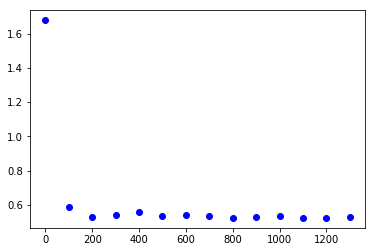

In [79]:
errors_rnneq=0
channels=0
data_heat_map_orig=0

train_eq_rnn(data_length, channel_length, channel_train, data_train, data_train_orig,
               channel_test,data_test, data_test_orig,errors_rnneq,channels,data_heat_map_orig,0)

[1.00000000e-04 2.63665090e-04 6.95192796e-04 1.83298071e-03
 4.83293024e-03 1.27427499e-02 3.35981829e-02 8.85866790e-02
 2.33572147e-01 6.15848211e-01 1.62377674e+00 4.28133240e+00
 1.12883789e+01 2.97635144e+01 7.84759970e+01 2.06913808e+02
 5.45559478e+02 1.43844989e+03 3.79269019e+03 1.00000000e+04]
SNR:  0
Noise added
Epoch 0, Train Cost 1.529639482498169, Test Cost: 100.09226989746094
Epoch 100, Train Cost 0.996218740940094, Test Cost: 0.994543731212616
Epoch 200, Train Cost 1.003171682357788, Test Cost: 1.000284194946289
Epoch 300, Train Cost 1.0055205821990967, Test Cost: 1.005740761756897
Epoch 400, Train Cost 1.0044032335281372, Test Cost: 1.0104013681411743
Epoch 500, Train Cost 1.0025211572647095, Test Cost: 1.0029574632644653
Epoch 600, Train Cost 1.0105915069580078, Test Cost: 1.0079413652420044
Epoch 700, Train Cost 1.005312204360962, Test Cost: 1.0036859512329102
Epoch 800, Train Cost 1.0104600191116333, Test Cost: 1.00479257106781
Epoch 900, Train Cost 1.0130500793457

Epoch 800, Train Cost 0.7237119674682617, Test Cost: 0.6547806859016418
Epoch 900, Train Cost 0.6823532581329346, Test Cost: 0.6488795280456543
SNR:  11
Noise added
Epoch 0, Train Cost 1.5252422094345093, Test Cost: 107.0063705444336
Epoch 100, Train Cost 0.6228919625282288, Test Cost: 0.6341639161109924
Epoch 200, Train Cost 0.6884704828262329, Test Cost: 0.6011413335800171
Epoch 300, Train Cost 0.5368199348449707, Test Cost: 0.5847325325012207
Epoch 400, Train Cost 0.6044632196426392, Test Cost: 0.5781809687614441
Epoch 500, Train Cost 0.6221070289611816, Test Cost: 0.567513108253479
Epoch 600, Train Cost 0.5850551128387451, Test Cost: 0.5531742572784424
Epoch 700, Train Cost 0.5547015070915222, Test Cost: 0.533855676651001
Epoch 800, Train Cost 0.5660467743873596, Test Cost: 0.5065829157829285
Epoch 900, Train Cost 0.5103222727775574, Test Cost: 0.46905389428138733
SNR:  12
Noise added
Epoch 0, Train Cost 1.4291441440582275, Test Cost: 106.11190795898438
Epoch 100, Train Cost 0.5917

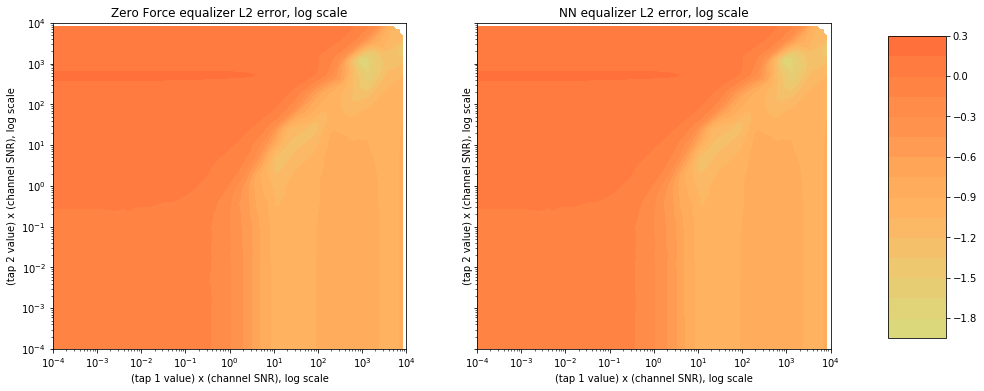

In [22]:
# generate heat plot for NN equalizer
n = 300 # number of channels
# m = 100 # number of tests for each SNR to be averaged

rad = np.linspace(0, 0.5*np.pi, n)
channels = np.vstack((np.cos(rad),np.sin(rad))).T
snrs = np.logspace(-4,4,20)
# snrs=np.array([1])
print(snrs)
errors_rnneq = np.zeros((n*len(snrs)))
channel_x = np.zeros((n*len(snrs)))
channel_y = np.zeros((n*len(snrs)))

data_length=100
data_heat_map_orig = 2*np.random.randint(2,size=data_length)-1

for i in range(len(snrs)):
    s = snrs[i]
    print("SNR: ",i)
    
    # add noise to data_train, data_test
    data_train_noise = data_train + (1./np.sqrt(s)) * np.random.randn(epochs*batch_size,data_length+1)
    data_test_noise = data_test + (1./np.sqrt(s)) * np.random.randn(num_test,data_length+1)
    print("Noise added")
    errors_rnneq = train_eq_rnn(data_length, channel_length, channel_train, data_train_noise, data_train_orig,
               channel_test,data_test_noise, data_test_orig,errors_rnneq,channels,data_heat_map_orig,i)

    channel_x[i*n:(i+1)*n] = channels[:,0]*s
    channel_y[i*n:(i+1)*n] = channels[:,1]*s


# zfEqualize(channel_output, channel):

heat_plot(channel_x, channel_y, errors_rnneq, errors_rnneq)

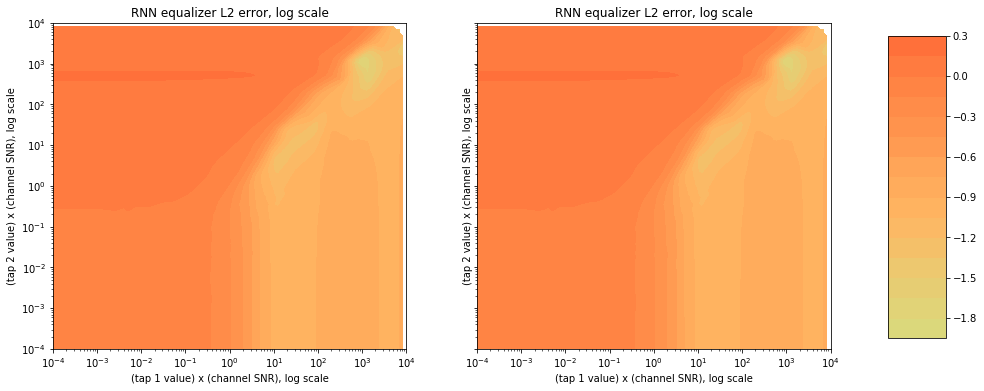

<class 'matplotlib.figure.Figure'>
[0.93407971 0.93416458 0.933568   ... 1.21954012 1.23774278 1.25500655]


In [37]:
heat_plot(channel_x, channel_y, errors_rnneq,errors_rnneq)

print(errors_rnneq)

# RNN with L inputs

In [7]:
import numpy as np
from numpy import linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
# fix random seed for reproducibility
np.random.seed()

learning_rate = 0.01
decay = 1 - 10*1e-10

batch_size = 100 # num of data streams
input_size = 2 # num of new conv data points to consider
state_size = 4 # num of est data points to use as state

batch_data_placeholder = tf.placeholder(tf.float32, [None, data_length+1])
batch_dataorig_placeholder = tf.placeholder(tf.float32, [None, data_length+1])

channel = tf.placeholder(tf.float32, [None, channel_length])

init_state = tf.placeholder(tf.float32, [None, state_size])

# Unpack columns
data = tf.unstack(batch_data_placeholder, axis=1)
data_orig = tf.unstack(batch_dataorig_placeholder, axis=1)

# Forward pass
current_state = init_state
est_data_series = []
for current_data in data:
    current_input = tf.reshape(current_data, [batch_size, input_size])

    # Increasing number of columns
    input_channel_state_concatenated = tf.concat([channel, current_state, current_input],1)  
    
    layer_1 = tf.layers.dense(
      input_channel_state_concatenated, 400, tf.nn.sigmoid, use_bias=True)
    layer_2 = tf.layers.dense(
      layer_1, 400, tf.nn.sigmoid, use_bias=True)
    layer_3 = tf.layers.dense(
      layer_2, state_size, activation=tf.identity, use_bias=True)

    next_state = layer_3
#     print(next_state[:,0])

    est_data_series.append(next_state[:,0])
#     print(est_data_series)
#     print(np.array(est_data_series).shape)
    current_state = next_state
    
# print(tf.size(est_data_series))
# print(tf.size(data_orig))

estimation_cost = tf.losses.mean_squared_error(data_orig, est_data_series)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(estimation_cost)
                                                                                  
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()


Epoch 0, Train Cost 1.5679101943969727, Test Cost: 106.6527328491211
Epoch 100, Train Cost 0.6237040758132935, Test Cost: 0.5800104737281799
Epoch 200, Train Cost 0.4972611367702484, Test Cost: 0.498434454202652
Epoch 300, Train Cost 0.4689291715621948, Test Cost: 0.4724094569683075
Epoch 400, Train Cost 0.34583115577697754, Test Cost: 0.4281701147556305
Epoch 500, Train Cost 0.36548569798469543, Test Cost: 0.3505837321281433
Epoch 600, Train Cost 0.32679232954978943, Test Cost: 0.27353519201278687
Epoch 700, Train Cost 0.257169246673584, Test Cost: 0.2170063555240631
Epoch 800, Train Cost 0.22336667776107788, Test Cost: 0.16754621267318726
Epoch 900, Train Cost 0.219032421708107, Test Cost: 0.17018869519233704


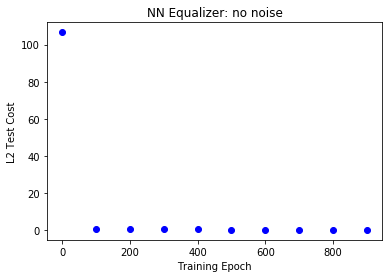

In [6]:
plt.figure()

# start the session
with tf.Session() as sess:
    #    initialize the variables
    sess.run(init_op)
    mc_losses = []
    
    for epoch in range(epochs):
        
        current_start = epoch*batch_size
        channel_train_batch = channel_train[current_start:(current_start+batch_size),:]
        data_train_batch = data_train[current_start:(current_start+batch_size),:]
        data_train_orig_batch = data_train_orig[current_start:(current_start+batch_size),:]
        
        # begin in state of all zeros
        begin_state = np.zeros((batch_size, state_size))
        
#         print(data_train_batch.shape)
#         print(channel_train_batch.shape)
#         print(data_train_orig_batch.shape)
#         print(begin_state.shape)
        _,cost,est_data_batch = sess.run([optimizer, estimation_cost, est_data_series], 
                                          feed_dict={batch_data_placeholder: data_train_batch, 
                                                     channel: channel_train_batch,
                                                     batch_dataorig_placeholder: data_train_orig_batch,
                                                     init_state: begin_state})    

        if epoch % 100 == 0: 
            
            
            mc_cost, mc_estimation = sess.run([estimation_cost, est_data_series], 
                                             feed_dict={batch_data_placeholder: data_test, 
                                                        channel: channel_test,
                                                        batch_dataorig_placeholder: data_test_orig,
                                                        init_state: begin_state})
            
            
            plt.plot(epoch, mc_cost, 'bo')
#             plt.plot(epoch, zero_force_error, 'ro')
#             plt.plot(epoch, mse_error, 'go')
            print('Epoch {}, Train Cost {}, Test Cost: {}'.format(epoch, cost, mc_cost))
#             plt.plot(epoch,cost,'bo')
#             print('Epoch {}, Train Cost {}'.format(epoch, cost))
            

plt.xlabel('Training Epoch')
plt.ylabel('L2 Test Cost')
plt.title('NN Equalizer: no noise')
# plt.text(1000, .025, r'NN equalizer')
# plt.text(0.5, .025, r'Zero Force equalizer')
plt.show()


In [19]:
channel_train.shape
channel_train[1:3,:]


array([[0.55719615, 0.8303809 ],
       [0.59052828, 0.80701695]])